# **Fase 1: Manipulación y preparación de datos**
### **Objetivo de este Notebook**

Este notebook documenta el proceso inicial y fundamental de **Análisis Exploratorio de Datos (EDA)** y preparación de datos para el proyecto de estimación de niveles de obesidad. El propósito es comprender a fondo el dataset, asegurar su calidad y transformarlo en un formato adecuado para el entrenamiento de modelos de Machine Learning.

Las tareas clave que se realizarán en este documento son:


1.   **Importar datos y Análisis Inicial**: Inspeccionar la estructura, tipos de datos y estadísticas descriptivas del dataset.
2.   **Limpieza de Datos**: Identificar y manejar valores nulos, duplicados, inconsistencias o posibles outliers.
3.  **Análisis Exploratorio (EDA)**: Utilizar visualizaciones para descubrir patrones, distribuciones y relaciones entre las variables.
4.  **Versionado de Datos con DVC**: Aplicar DVC (Data Version Control) para registrar las versiones del dataset (crudo y limpio), garantizando la trazabilidad y reproducibilidad de nuestro trabajo.

Esta fase es crucial, ya que la calidad de los datos impacta directamente en el rendimiento y la fiabilidad de cualquier modelo que construyamos posteriormente.

### **Descripción del Problema**

El dataset "Estimation of Obesity Levels Based On Eating Habits and Physical Condition" contiene datos de individuos de México, Perú y Colombia, con atributos relacionados con hábitos alimenticios, condición física y estilo de vida. El objetivo es predecir el nivel de obesidad de una persona, clasificado en siete categorías: **Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, y Obesity Type III.**

### **Propuesta de Valor**

Desarrollar un modelo de clasificación que permita identificar el nivel de obesidad de un individuo a partir de sus hábitos y características físicas. Esto puede ser útil para sistemas de recomendación, monitoreo de salud preventiva y campañas de concientización.

### **Herramientas y Documentación**

Para la manipulación y análisis de datos se utilizarán principalmente las librerías de Python **Pandas, Matplotlib y Seaborn**. El versionado de los artefactos de datos se gestionará con **DVC**.

Para la documentación estratégica del proyecto, incluyendo el mapeo de requerimientos, stakeholders y métricas de éxito, se utilizó el framework **ML Canvas.**

# 0.- Importar librerias

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import math

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Ignorar warning
import warnings
warnings.filterwarnings('ignore')

# Prueba Estadística (Chi-Cuadrado)
from scipy.stats import chi2_contingency


# **0.- Funciones**

In [2]:
# Función para analisis Inicial
def resumen_eda(df: pd.DataFrame, target_column: str = None):

  """
    Realiza un análisis exploratorio de datos inicial y completo sobre un DataFrame.

    Esta función imprime un resumen que incluye:
    1. Dimensiones del DataFrame.
    2. Tipos de datos y uso de memoria.
    3. Una muestra aleatoria de los datos.
    4. Conteo de valores nulos y filas duplicadas.
    5. Estadísticas descriptivas para variables numéricas y categóricas por separado.
    6. Distribución de la variable objetivo (si se especifica).

    Args:
        df (pd.DataFrame): El DataFrame que se va a analizar.
        target_column (str, optional): El nombre de la columna objetivo.
                                       Si se proporciona, se mostrará su distribución.
                                       Defaults to None.
    """

  # Imprime un título principal para el reporte
  display(Markdown("---"))
  display(Markdown("## **Análisis Exploratorio del Dataset**"))
  display(Markdown("---"))

  # 1. Dimensiones del DataFrame
  display(Markdown("### 1. Dimensiones del Dataset"))
  print(f"Número de Filas:    {df.shape[0]:,}")
  print(f"Número de Columnas: {df.shape[1]}")
  print("\n")

  # 2. Tipos de datos y memoria
  display(Markdown("### 2. Tipos de Datos y Uso de Memoria"))
  df.info()
  print("\n")

  # 3. Muestra aleatoria de los datos
  display(Markdown("### 3. Muestra Aleatoria de Datos"))
  display(df.sample(5))
  print("\n")

  # 4. Calidad de los Datos
  display(Markdown("### 4. Calidad de los Datos"))
  nulos = df.isnull().sum()
  duplicados = df.duplicated().sum()
  print(f"Número total de filas duplicadas: {duplicados}")
  print("Conteo de valores nulos por columna:")
  # Muestra solo las columnas que tienen valores nulos para no saturar la salida
  if nulos.sum() == 0:
      print("No se encontraron valores nulos.")
  else:
      print(nulos[nulos > 0])
  print("\n")

  # 5. Estadísticas Descriptivas
  display(Markdown("### 5. Estadísticas Descriptivas"))

  # Columnas numéricas
  display(Markdown("#### **Variables Numéricas**"))
  display(df[variables_numericas].describe().T)

  # Columnas categóricas
  display(Markdown("#### **Variables Categóricas**"))
  display(df[variables_categoricas].describe(include=['object', 'category']).T)
  print("\n")

# 6. Análisis de la Variable Objetivo
  if target_column:
      if target_column in df.columns:
          display(Markdown(f"### 6. Distribución de la Variable Objetivo: '{target_column}'"))
          distribucion = pd.DataFrame({
              'Frecuencia': df[target_column].value_counts(),
              'Porcentaje (%)': df[target_column].value_counts(normalize=True).mul(100).round(2)
          })
          display(distribucion)
      else:
          print(f"Advertencia: La columna objetivo '{target_column}' no se encontró en el DataFrame.")

In [3]:
def limpiar_y_detectar_atipicos(df: pd.DataFrame, target_column: str, cols_to_drop: list = None) -> pd.DataFrame:
  """
  Realiza un proceso completo de limpieza de datos y detección de atípicos.

  Esta función ejecuta los siguientes pasos en orden:
  1. Crea una copia del DataFrame para evitar modificaciones inesperadas.
  2. Estandariza los nombres de las columnas (minúsculas, sin espacios).
  3. Elimina columnas irrelevantes y filas duplicadas.
  4. Elimina filas donde la variable objetivo es nula.
  5. Estandariza los valores de las columnas categóricas.
  6. Convierte columnas a tipo numérico, forzando errores a NaN.
  7. Estandariza los valores de las columna objetivo (Codificación Numérica Ordinal).
  8. Imputa valores nulos: mediana para numéricos y moda para categóricos.
  9. Detecta y reporta datos atípicos (outliers) usando el método IQR.

  Args:
      df (pd.DataFrame): El DataFrame de entrada a limpiar.
      target_column (str): El nombre de la columna objetivo.
      cols_to_drop (list, optional): Lista de nombres de columnas a eliminar. Defaults to None.

  Returns:
      pd.DataFrame: Un nuevo DataFrame limpio y con los valores nulos imputados.
  """
  display(Markdown("---"))
  display(Markdown("## **Proceso de Limpieza y Detección de Atípicos**"))
  display(Markdown("---"))

  # 1. Crear una copia para no modificar el original
  df_limpio = df.copy()

  # 2. Estandarizar nombres de columnas
  print("1. Estandarizando nombres de columnas...")
  df_limpio.columns = df_limpio.columns.str.strip().str.replace(' ', '_').str.lower()
  # Asegurarnos que el target_column también esté en minúsculas para consistencia
  target_column = target_column.lower()

  # 3. Eliminar columnas y duplicados
  print("2. Eliminando columnas irrelevantes y duplicados...")
  df_limpio.drop(columns=cols_to_drop, inplace=True, axis=1)
  variables_numericas.remove(cols_to_drop)

  df_limpio.drop_duplicates(inplace=True)
  df_limpio.dropna(subset=[target_column], inplace=True)

  # 4. Estandarizar valores categóricos
  print("3. Estandarizando valores en columnas categóricas...")
  for col in variables_categoricas + [target_column]:
      df_limpio[col] = df_limpio[col].str.strip().str.replace(' ', '_').str.lower()
      df_limpio = df_limpio[df_limpio[col] != 'nan']

  # 5. Forzar tipos de datos numéricos
  print("4. Asegurando tipos de datos numéricos...")
  for col in variables_numericas:
      df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce')

  # 6. Asignar un numero a la variable objetivo
  mapeo_obesity = {
    'insufficient_weight': 0,
    'normal_weight': 1,
    'overweight_level_i': 2,
    'overweight_level_ii': 3,
    'obesity_type_i': 4,
    'obesity_type_ii': 5,
    'obesity_type_iii': 6
    }

  # Aplicar el mapeo a la columna objetivo.
  df_limpio[target_column] = df_limpio[target_column].map(mapeo_obesity)

  # 7. Imputación de valores nulos
  print("5. Imputando valores nulos...")
  # Imputar numéricas con la mediana
  for col in variables_numericas:
      if df_limpio[col].isnull().any():
          mediana = df_limpio[col].median()
          df_limpio[col].fillna(mediana, inplace=True)

  # Imputar categóricas con la moda
  for col in variables_categoricas:
      if df_limpio[col].isnull().any():
          moda = df_limpio[col].mode()[0]
          df_limpio[col].fillna(moda, inplace=True)

  print("   - No se encontraron más valores nulos.")

  # 8. Detección de Datos Atípicos (Outliers) con IQR
  display(Markdown("### Detección de Atípicos (Método IQR)"))
  for col in variables_numericas:
      Q1 = df_limpio[col].quantile(0.25)
      Q3 = df_limpio[col].quantile(0.75)
      IQR = Q3 - Q1
      limite_inferior = Q1 - 3 * IQR
      limite_superior = Q3 + 3 * IQR

      # Filtrar outliers
      outliers = df_limpio[(df_limpio[col] <= limite_inferior) | (df_limpio[col] >= limite_superior)]

      if not outliers.empty:
          porcentaje = (len(outliers) / len(df_limpio)) * 100
          print(f"\nColumna '{col}':")
          print(f"  - Límite inferior: {limite_inferior:.2f}")
          print(f"  - Límite superior: {limite_superior:.2f}")
          print(f"  - Número de atípicos encontrados: {len(outliers)}")
          print(f"  - Porcentaje de atípicos: {porcentaje:.2f}%")

  display(Markdown("---"))
  print("\nProceso de limpieza finalizado.")

  return df_limpio

In [4]:
def eliminar_atipicos(
    df: pd.DataFrame,
    age_range: tuple = (1, 50),
    height_max: float = 2.5,
    ncp_max: float = 10.0,
    iqr_factor: float = 1.5
) -> pd.DataFrame:
  """
  Elimina datos atípicos de un DataFrame utilizando una estrategia mixta.

  Aplica reglas de negocio específicas para columnas conocidas y el método IQR
  para el resto de las variables numéricas.

  Args:
      df (pd.DataFrame): DataFrame limpio (idealmente el resultado de la función de limpieza).
      age_range (tuple, optional): Rango (mín, máx) de edad a conservar. Defaults to (1, 50).
      height_max (float, optional): Altura máxima en metros a conservar. Defaults to 2.5.
      ncp_max (float, optional): Número máximo de comidas principales a conservar. Defaults to 10.0.
      iqr_factor (float, optional): Factor para multiplicar el IQR y definir los límites. Defaults to 1.5.

  Returns:
      pd.DataFrame: Un nuevo DataFrame sin los datos atípicos.
  """
  display(Markdown("---"))
  display(Markdown("## **Proceso de Eliminación de Atípicos**"))
  display(Markdown("---"))

  df_tratado = df.copy()
  filas_iniciales = len(df_tratado)

  # 1. Aplicar reglas de negocio específicas
  print("1. Aplicando reglas de negocio para 'age', 'height' y 'ncp'...")

  # Columnas con reglas específicas
  columnas_con_reglas = ['age', 'height', 'ncp']

  if 'age' in df_tratado.columns:
      df_tratado = df_tratado[(df_tratado['age'] >= age_range[0]) & (df_tratado['age'] <= age_range[1])]

  if 'height' in df_tratado.columns:
      df_tratado = df_tratado[df_tratado['height'] < height_max]

  if 'ncp' in df_tratado.columns:
      df_tratado = df_tratado[df_tratado['ncp'] < ncp_max]

  filas_despues_reglas = len(df_tratado)
  print(f"   - Se eliminaron {filas_iniciales - filas_despues_reglas} filas con reglas de negocio.")

  # 2. Aplicar método IQR para el resto de variables numéricas
  print("\n2. Aplicando método IQR para el resto de variables numéricas...")

  variables_numericas = df_tratado.select_dtypes(include=np.number).columns
  columnas_para_iqr = [col for col in variables_numericas if col not in columnas_con_reglas]

  for col in columnas_para_iqr:
      Q1 = df_tratado[col].quantile(0.25)
      Q3 = df_tratado[col].quantile(0.75)
      IQR = Q3 - Q1
      limite_inferior = Q1 - iqr_factor * IQR
      limite_superior = Q3 + iqr_factor * IQR

      # Mantener solo las filas dentro de los límites
      df_tratado = df_tratado[(df_tratado[col] >= limite_inferior) & (df_tratado[col] <= limite_superior)]

  filas_despues_iqr = len(df_tratado)
  print(f"   - Se eliminaron {filas_despues_reglas - filas_despues_iqr} filas adicionales con el método IQR.")

  # 3. Reporte final
  display(Markdown("### Reporte Final de Eliminación"))

  filas_finales = len(df_tratado)
  filas_eliminadas = filas_iniciales - filas_finales
  porcentaje_eliminado = (filas_eliminadas / filas_iniciales) * 100

  print(f"Filas iniciales: {filas_iniciales:,}")
  print(f"Filas finales:   {filas_finales:,}")
  print(f"Total de filas eliminadas: {filas_eliminadas:,} ({porcentaje_eliminado:.2f}%)")

  display(Markdown("---"))
  print("\nProceso de eliminación de atípicos finalizado.")

  return df_tratado

In [5]:
def analisis_exploratorio_numerico(df: pd.DataFrame, num_cols: list, target_col: str):
  """
  Realizar un completo análisis exploratorio (EDA) para las variables numéricas de un DataFrame.

  Esta función genera y muestra:
  1. Un resumen estadístico, incluyendo asimetría y curtosis.
  2. Histogramas y diagramas de caja para cada variable (análisis univariado).
  3. Un mapa de calor de correlación entre las variables numéricas.
  4. Un análisis de la relación entre cada variable numérica y la variable objetivo.

  Args:
      df (pd.DataFrame): El DataFrame a analizar.
      num_cols (list): Una lista con los nombres de las columnas numéricas.
      target_col (str): El nombre de la columna objetivo (categórica).
  """
  display(Markdown("---"))
  display(Markdown("## **Análisis Exploratorio de Variables Numéricas**"))
  display(Markdown("---"))

  # --- 1. Resumen Estadístico ---
  display(Markdown("### 1. Resumen Estadístico"))
  resumen = df[num_cols].describe().T
  resumen['skewness'] = df[num_cols].skew()
  resumen['kurtosis'] = df[num_cols].kurt()
  display(resumen)

  # --- 2. Análisis de Distribución (Univariado) ---
  display(Markdown("\n### 2. Distribución de Cada Variable Numérica"))
  n_filas = int(np.ceil(len(num_cols) / 4))
  fig, axes = plt.subplots(n_filas, 4, figsize=(14, n_filas * 3))
  axes = axes.flatten()

  for i, col in enumerate(num_cols):
      sns.histplot(df[col], ax=axes[i], bins=10, color = '#41abc0')
      axes[i].axvline(x = df[col].mean(), color='red', linestyle='-.')
      axes[i].set_title(f'Distribución de {col}', fontsize=10)

  # Ocultar ejes sobrantes si el número de variables es impar
  for j in range(len(num_cols), len(axes)):
      axes[j].set_visible(False)

  plt.tight_layout()
  plt.show()

  # --- 3. Análisis de Correlación entre Variables Numéricas ---
  display(Markdown("\n### 3. Mapa de Calor de Correlación"))
  plt.figure(figsize=(8, 6))
  correlation_matrix = df[num_cols + [target_col]].corr(method='pearson')
  sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
  plt.title('Correlación entre Variables Numéricas', fontsize=14)
  plt.show()

  # --- 4. Relación con la Variable Objetivo ---
  display(Markdown(f"\n### 4. Relación de Variables Numéricas con '{target_col}'"))

  # Tabla resumen con la media por categoría
  display(Markdown("#### **Media de cada variable por categoría de obesidad**"))
  media_por_categoria = df.groupby(target_col)[num_cols].mean().round(2)
  display(media_por_categoria)

  # Gráficos de caja para visualizar la distribución
  display(Markdown("#### **Distribución de cada variable por categoría de obesidad**"))
  n_filas_target = int(np.ceil(len(num_cols) / 3))
  fig, axes = plt.subplots(n_filas_target, 3, figsize=(15, n_filas_target * 4))
  axes = axes.flatten()

  # Ordenar las categorías de la variable objetivo de manera lógica
  order = sorted(df[target_col].unique())

  for i, col in enumerate(num_cols):
      sns.boxplot(x=target_col, y=col, data=df, ax=axes[i], order=order, palette='viridis')
      axes[i].set_title(f'{col} vs. {target_col}', fontsize=12)
      axes[i].tick_params(axis='x', rotation=45)

  for j in range(len(num_cols), len(axes)):
      axes[j].set_visible(False)

  plt.tight_layout()
  plt.show()

In [6]:
def analisis_exploratorio_categorico(df: pd.DataFrame, cat_cols: list, target_col: str):
  """
  Realizar un completo análisis exploratorio (EDA) para las variables categóricas.

  Genera y muestra:
  1. Un resumen estadístico de las variables categóricas.
  2. Gráficos de barras para visualizar la distribución de cada variable.
  3. Gráficos de barras apiladas al 100% para analizar la proporción de la variable
      objetivo en cada categoría.
  4. Una prueba de Chi-cuadrado para determinar la significancia estadística de la
      asociación entre cada variable y el objetivo.

  Args:
      df (pd.DataFrame): El DataFrame a analizar.
      cat_cols (list): Lista con los nombres de las columnas categóricas.
      target_col (str): El nombre de la columna objetivo.
  """
  display(Markdown("---"))
  display(Markdown("## **Análisis Exploratorio de Variables Categóricas**"))
  display(Markdown("---"))

  # --- 1. Resumen Estadístico ---
  display(Markdown("### 1. Resumen Estadístico"))
  display(df[cat_cols].describe().T)

  # --- 2. Análisis de Distribución (Univariado) ---
  display(Markdown("\n### 2. Distribución de Cada Variable Categórica"))
  n_filas = int(np.ceil(len(cat_cols) / 4))
  fig, axes = plt.subplots(n_filas, 4, figsize=(16, n_filas * 3))
  axes = axes.flatten()

  for i, col in enumerate(cat_cols):
      sns.countplot(data=df, y=col, order=df[col].value_counts().index, ax=axes[i], color = '#41abc0')
      axes[i].set_title(f'Distribución de {col}', fontsize=10)
      axes[i].set_xlabel('Frecuencia')
      axes[i].set_ylabel('')

  # Ocultar ejes sobrantes
  for j in range(len(cat_cols), len(axes)):
      axes[j].set_visible(False)

  plt.tight_layout()
  plt.show()

  # --- 3. Relación con la Variable Objetivo (Gráficos de Proporción) ---
  display(Markdown(f"\n### 3. Relación con la Variable Objetivo: '{target_col}'"))
  n_filas = int(np.ceil(len(cat_cols) / 4))
  # Crear la figura y los ejes (subplots)
  fig, axes = plt.subplots(n_filas, 4, figsize=(16, n_filas * 4))
  # Aplanar el array de ejes para poder iterar con un solo índice
  axes = axes.flatten()

  for i, col in enumerate(cat_cols):
      # Seleccionar el eje actual donde se va a graficar
      ax = axes[i]

      # Crear tabla de contingencia y normalizar para obtener porcentajes
      contingency_table = pd.crosstab(df[col], df[target_col], normalize='index') * 100

      # Graficar en el eje especificado (ax=ax)
      contingency_table.plot(kind='bar', stacked=True, ax=ax,  colormap='viridis', width=0.8)

      # Configurar títulos y etiquetas usando el objeto 'ax' para este subplot
      ax.set_title(f'Proporción de Obesidad por {col}', fontsize=10)
      ax.set_xlabel('') # El nombre de la columna ya es visible en el título
      ax.set_ylabel('Porcentaje (%)')
      ax.tick_params(axis='x', rotation=0) # Rotar etiquetas si son largas
      ax.legend(title=target_col, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left') # Ajustar la leyenda para el subplot

  # Ocultar los ejes sobrantes si el número de gráficos es impar
  for j in range(len(cat_cols), len(axes)):
      axes[j].set_visible(False)

  # Ajustar el layout para evitar solapamientos y mostrar la figura completa
  plt.tight_layout()
  plt.show()

  # --- 4. Prueba de Asociación Estadística (Chi-Cuadrado) ---
  display(Markdown("\n### 4. Prueba de Asociación Estadística (Chi-Cuadrado)"))

  chi2_results = []
  for col in cat_cols:
      contingency_table = pd.crosstab(df[col], df[target_col])
      chi2, p_value, _, _ = chi2_contingency(contingency_table)
      chi2_results.append({'Variable': col, 'Chi2 Statistic': chi2, 'P-Value': p_value})

  results_df = pd.DataFrame(chi2_results)
  results_df['Asociación Significativa (p < 0.05)'] = results_df['P-Value'] < 0.05

  display(results_df.sort_values(by='P-Value'))

In [7]:
def analisis_variable_objetivo(df: pd.DataFrame, target_col: str, num_cols: list, cat_cols: list):
  """
  Realiza un análisis profundo y detallado de la variable objetivo categórica.

  Este análisis incluye:
  1.  Distribución de clases para identificar desbalances.
  2.  Perfil categórico (moda) para cada clase.

  Args:
      df (pd.DataFrame): El DataFrame a analizar.
      target_col (str): El nombre de la columna objetivo.
      num_cols (list): Lista de columnas numéricas para el perfilado.
      cat_cols (list): Lista de columnas categóricas para el perfilado.
  """
  display(Markdown("---"))
  display(Markdown(f"## **Análisis de la Variable Objetivo: '{target_col}'**"))
  display(Markdown("---"))

  # --- 1. Análisis de Distribución y Desbalance ---
  display(Markdown("### 1. Distribución de las Clases"))

  # Gráfico de barras
  plt.figure(figsize=(10, 5))
  sns.countplot(data=df, y=target_col, order=df[target_col].value_counts().index, palette='viridis')
  plt.title(f'Distribución de Frecuencias de {target_col}', fontsize=14)
  plt.xlabel('Categoría', fontsize=10)
  plt.ylabel('Frecuencia', fontsize=10)
  plt.xticks(rotation=45)
  plt.show()

  # --- 2. Perfil Categórico por Categoría ---
  display(Markdown("\n### 2. Perfil Categórico Más Común (Moda) por Categoría"))
  display(Markdown("Esta tabla muestra el hábito o característica más frecuente para cada nivel de obesidad."))

  # Usamos una función lambda para obtener la moda de cada grupo
  perfil_categorico = df.groupby(target_col)[cat_cols].agg(lambda x: x.mode()[0])
  display(perfil_categorico)

In [8]:
# Guardar el DataFrame final en Google Drive
def guardar_dataframe_en_drive(df, nombre_archivo):
  output_path = '/content/drive/MyDrive/Maestría MNA/Trimestre 4 Sep-Dic 25/Operaciones de aprendizaje automático/Edén/Proyecto/'
  df.to_csv(output_path + nombre_archivo + '.csv', index=False)
  print(f"DataFrame guardado exitosamente en: {output_path}")

# **1.- Importar datos y Análisis Inicial**

In [13]:
# Cargar el archivo CSV `obesity_estimation_original.csv` desde Google Drive en un DataFrame de pandas.
file_path = '/content/drive/MyDrive/Maestría MNA/Trimestre 4 Sep-Dic 25/Operaciones de aprendizaje automático/Edén/Proyecto/obesity_estimation_modified.csv'
df = pd.read_csv(file_path)

In [14]:
# Crear una lista con las variables númericas
variables_numericas = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'mixed_type_col']

# Crear una lista con las variables cualitativas
variables_categoricas = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Definir la variable objetivo
variable_objetivo = 'NObeyesdad'

# Llamar a la función (resumen_inicial_eda) especificando la variable objetivo
resumen_eda(df, variable_objetivo)

---

## **Análisis Exploratorio del Dataset**

---

### 1. Dimensiones del Dataset

Número de Filas:    2,153
Número de Columnas: 18




### 2. Tipos de Datos y Uso de Memoria

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Gender                          2135 non-null   object
 1   Age                             2126 non-null   object
 2   Height                          2125 non-null   object
 3   Weight                          2137 non-null   object
 4   family_history_with_overweight  2133 non-null   object
 5   FAVC                            2137 non-null   object
 6   FCVC                            2136 non-null   object
 7   NCP                             2129 non-null   object
 8   CAEC                            2131 non-null   object
 9   SMOKE                           2134 non-null   object
 10  CH2O                            2124 non-null   object
 11  SCC                             2138 non-null   object
 12  FAF                             2124 non-null   

### 3. Muestra Aleatoria de Datos

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,mixed_type_col
1525,Male,30.605225,1.75,120.0,yes,YES,2.758394,3.0,Sometimes,yes,2.174248,no,1.079524,1.358163,Sometimes,Automobile,Obesity_Type_II,568
1146,Male,31.264628,1.803129,91.052215,yes,yes,2.0,3.0,Sometimes,no,1.199517,no,0.047738,0.163329,Sometimes,Public_Transportation,Overweight_Level_II,943
54,Female,22.0,1.6,55.0,no,no,3.0,NaN,Always,NO,3.0,no,2.0,0.0,no,Public_Transportation,Normal_Weight,bad
597,Male,18.0,1.7108,50.92538,yes,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,1.593704,Sometimes,Public_Transportation,Insufficient_Weight,NaN
1599,Male,20.184451,1.701284,104.578255,yes,yes,2.653721,1.265463,Sometimes,no,1.368457,no,0.218356,0.768071,no,pUBLIC_tRANSPORTATION,Obesity_Type_II,bad


### 4. Calidad de los Datos

Número total de filas duplicadas: 1
Conteo de valores nulos por columna:
Gender                             18
Age                                27
Height                             28
Weight                             16
family_history_with_overweight     20
FAVC                               16
FCVC                               17
NCP                                24
CAEC                               22
SMOKE                              19
CH2O                               29
SCC                                15
FAF                                29
TUE                                33
CALC                               23
MTRANS                             23
NObeyesdad                         20
mixed_type_col                    241
dtype: int64




### 5. Estadísticas Descriptivas

#### **Variables Numéricas**

,count,unique,top,freq
Age,2126,1410,18.0,120
Height,2125,1572,1.7,55
Weight,2137,1551,80.0,56
FCVC,2136,818,3.0,616
NCP,2129,646,3.0,1146
CH2O,2124,1269,2.0,425
FAF,2124,1196,0.0,386
TUE,2120,1129,0.0,521
mixed_type_col,1912,775,unknown,231


#### **Variables Categóricas**

,count,unique,top,freq
Gender,2135,4,Male,1040
family_history_with_overweight,2133,5,yes,1662
FAVC,2137,4,yes,1813
CAEC,2131,8,Sometimes,1677
SMOKE,2134,5,no,1993
SCC,2138,4,no,1924
CALC,2130,8,Sometimes,1343
MTRANS,2130,9,Public_Transportation,1512


### 6. Distribución de la Variable Objetivo: 'NObeyesdad'

,Frecuencia,Porcentaje (%)
NObeyesdad,,
Obesity_Type_I,337,15.80
Obesity_Type_III,314,14.72
Obesity_Type_II,287,13.46
Overweight_Level_I,285,13.36
Overweight_Level_II,280,13.13
Normal_Weight,271,12.71
Insufficient_Weight,261,12.24
nORMAL_wEIGHT,17,0.80
oBESITY_tYPE_i,16,0.75


# **2.- Limpieza de Datos**

In [15]:
variables_numericas = [variable.lower() for variable in variables_numericas]
variables_categoricas = [variable.lower() for variable in variables_categoricas]
variable_objetivo = variable_objetivo.lower()

# Paso 1: Limpiar y preparar los datos
df_limpio = limpiar_y_detectar_atipicos(df, variable_objetivo, 'mixed_type_col')

# Paso 2: Eliminar los atípicos del dataframe ya limpio
df_final = eliminar_atipicos(df_limpio, age_range=(1, 50), height_max=2.5, ncp_max=10.0, iqr_factor=1.5)
df_final.head()

---

## **Proceso de Limpieza y Detección de Atípicos**

---

1. Estandarizando nombres de columnas...
2. Eliminando columnas irrelevantes y duplicados...
3. Estandarizando valores en columnas categóricas...
4. Asegurando tipos de datos numéricos...
5. Imputando valores nulos...
   - No se encontraron más valores nulos.


### Detección de Atípicos (Método IQR)


Columna 'age':
  - Límite inferior: 2.00
  - Límite superior: 44.00
  - Número de atípicos encontrados: 36
  - Porcentaje de atípicos: 1.70%

Columna 'height':
  - Límite inferior: 1.22
  - Límite superior: 2.18
  - Número de atípicos encontrados: 19
  - Porcentaje de atípicos: 0.90%

Columna 'weight':
  - Límite inferior: -60.58
  - Límite superior: 234.84
  - Número de atípicos encontrados: 19
  - Porcentaje de atípicos: 0.90%

Columna 'fcvc':
  - Límite inferior: -1.00
  - Límite superior: 6.00
  - Número de atípicos encontrados: 20
  - Porcentaje de atípicos: 0.95%

Columna 'ncp':
  - Límite inferior: 1.80
  - Límite superior: 3.90
  - Número de atípicos encontrados: 455
  - Porcentaje de atípicos: 21.52%

Columna 'ch2o':
  - Límite inferior: -1.06
  - Límite superior: 5.18
  - Número de atípicos encontrados: 21
  - Porcentaje de atípicos: 0.99%

Columna 'faf':
  - Límite inferior: -4.44
  - Límite superior: 6.29
  - Número de atípicos encontrados: 27
  - Porcentaje de atípicos: 1

---


Proceso de limpieza finalizado.


---

## **Proceso de Eliminación de Atípicos**

---

1. Aplicando reglas de negocio para 'age', 'height' y 'ncp'...
   - Se eliminaron 69 filas con reglas de negocio.

2. Aplicando método IQR para el resto de variables numéricas...
   - Se eliminaron 99 filas adicionales con el método IQR.


### Reporte Final de Eliminación

Filas iniciales: 2,114
Filas finales:   1,946
Total de filas eliminadas: 168 (7.95%)


---


Proceso de eliminación de atípicos finalizado.


,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,female,21.0,1.62,64.0,yes,no,2.0,3.0,sometimes,no,2.0,no,0.0,1.0,no,public_transportation,1
1,female,21.0,1.52,56.0,yes,no,3.0,3.0,sometimes,yes,3.0,yes,3.0,0.0,sometimes,public_transportation,1
2,male,23.0,1.80,77.0,yes,no,2.0,3.0,sometimes,no,2.0,no,2.0,1.0,frequently,public_transportation,1
3,male,27.0,1.80,87.0,no,no,3.0,3.0,sometimes,no,2.0,no,2.0,0.0,frequently,walking,2
4,male,22.0,1.78,89.8,no,no,2.0,1.0,sometimes,no,2.0,no,0.0,0.0,sometimes,public_transportation,3


# **3.- Análisis Exploratorio (EDA)**

## 3.1.- Variables númericas

---

## **Análisis Exploratorio de Variables Numéricas**

---

### 1. Resumen Estadístico

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,1946.0,24.148324,5.938280,15.000000,19.983146,22.851804,26.000000,47.706100,1.280630,1.267018
height,1946.0,1.704715,0.092479,1.456346,1.634428,1.704180,1.770093,1.980000,-0.044709,-0.512069
weight,1946.0,86.897181,25.951658,39.101805,66.031741,83.544074,108.017559,165.057269,0.215544,-0.742292
fcvc,1946.0,2.420032,0.528187,1.000000,2.000000,2.408561,3.000000,3.000000,-0.428384,-0.628485
ncp,1946.0,2.691787,0.766672,1.000000,2.696268,3.000000,3.000000,4.000000,-1.136867,0.478322
ch2o,1946.0,2.016276,0.604417,1.000000,1.622270,2.000000,2.479917,3.000000,-0.119871,-0.830984
faf,1946.0,1.021618,0.844441,0.000000,0.159962,1.000000,1.663930,3.000000,0.479091,-0.618850
tue,1946.0,0.672193,0.604946,0.000000,0.001754,0.632467,1.000000,2.000000,0.596416,-0.543372



### 2. Distribución de Cada Variable Numérica

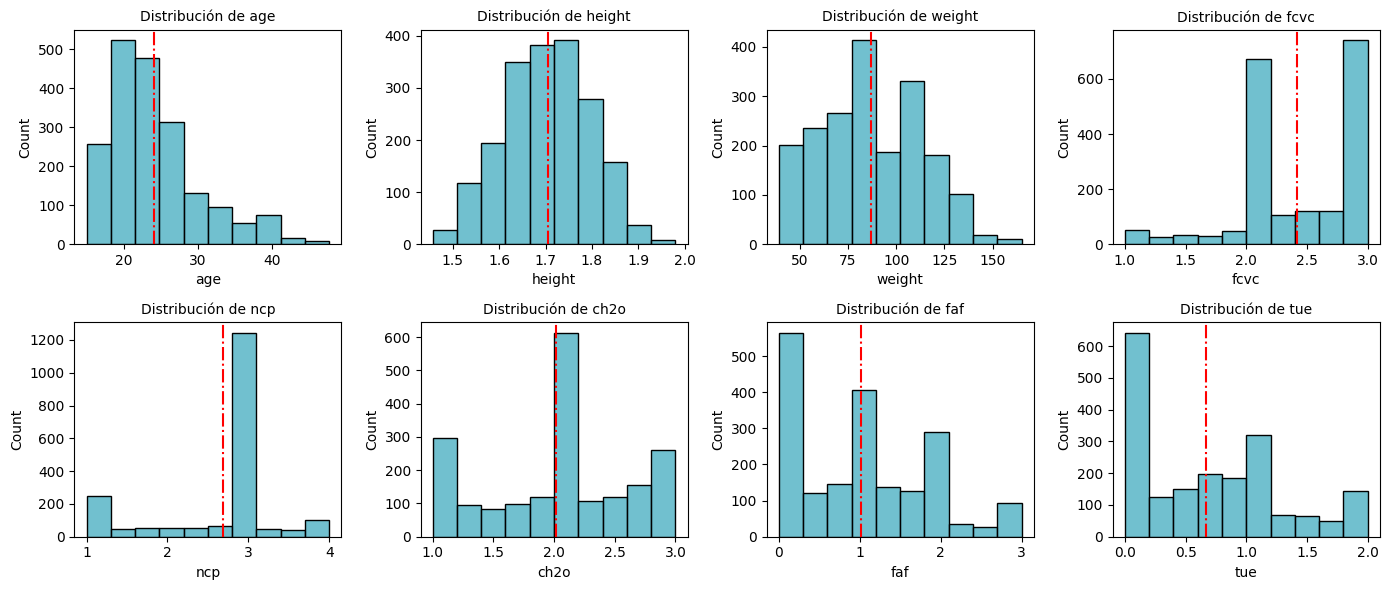


### 3. Mapa de Calor de Correlación

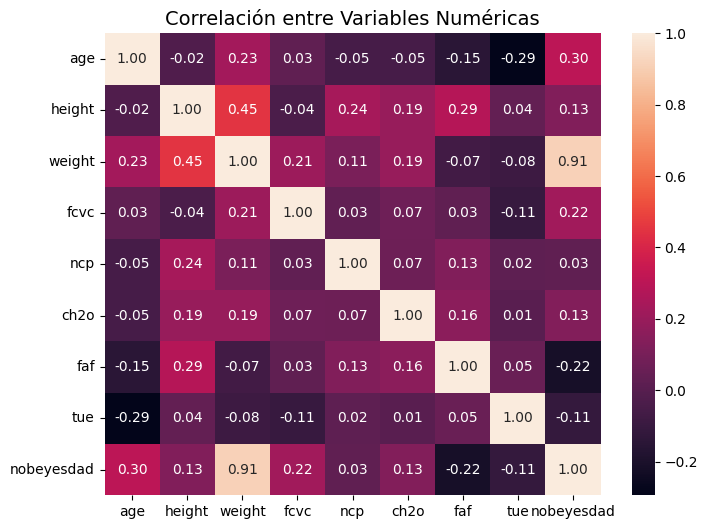


### 4. Relación de Variables Numéricas con 'nobeyesdad'

#### **Media de cada variable por categoría de obesidad**

,age,height,weight,fcvc,ncp,ch2o,faf,tue
nobeyesdad,,,,,,,,
0,19.80,1.69,50.07,2.49,2.92,1.89,1.28,0.85
1,21.57,1.68,62.92,2.33,2.74,1.85,1.30,0.70
2,23.31,1.69,74.56,2.28,2.52,2.06,1.06,0.61
3,26.43,1.71,82.41,2.26,2.50,2.03,0.96,0.73
4,25.54,1.70,93.50,2.18,2.45,2.13,1.00,0.72
5,28.13,1.77,115.03,2.39,2.75,1.88,0.95,0.52
6,23.52,1.69,119.96,2.99,3.00,2.22,0.67,0.60


#### **Distribución de cada variable por categoría de obesidad**

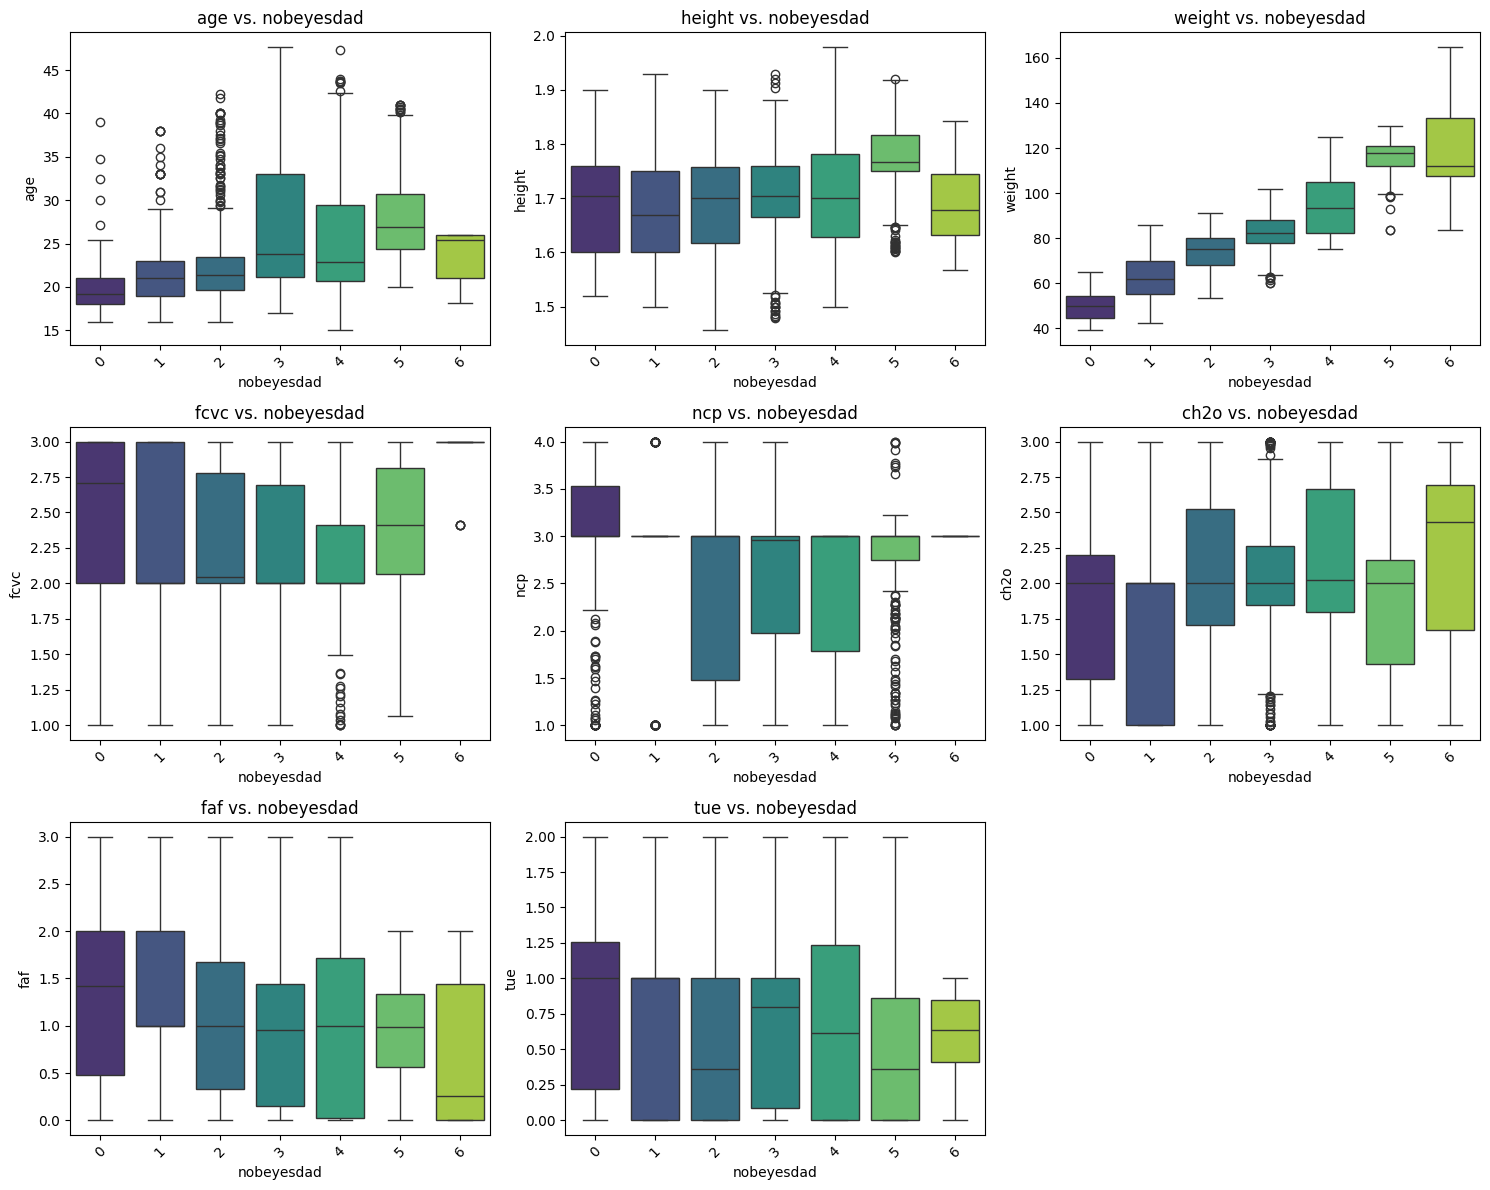

In [16]:
analisis_exploratorio_numerico(df_final, variables_numericas, variable_objetivo)

## 3.2.- Variables categóricas

---

## **Análisis Exploratorio de Variables Categóricas**

---

### 1. Resumen Estadístico

,count,unique,top,freq
gender,1946,2,male,1013
family_history_with_overweight,1946,2,yes,1608
favc,1946,2,yes,1727
caec,1946,4,sometimes,1640
smoke,1946,2,no,1908
scc,1946,2,no,1860
calc,1946,4,sometimes,1318
mtrans,1946,5,public_transportation,1461



### 2. Distribución de Cada Variable Categórica

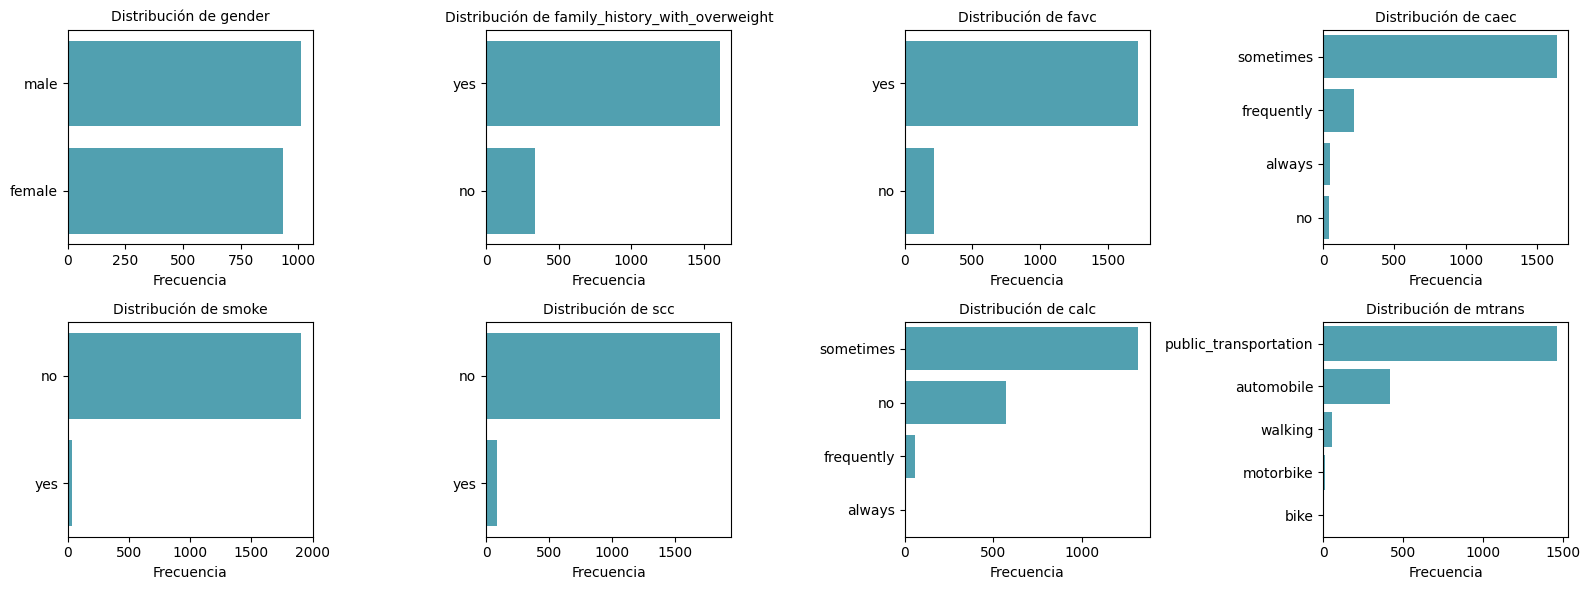


### 3. Relación con la Variable Objetivo: 'nobeyesdad'

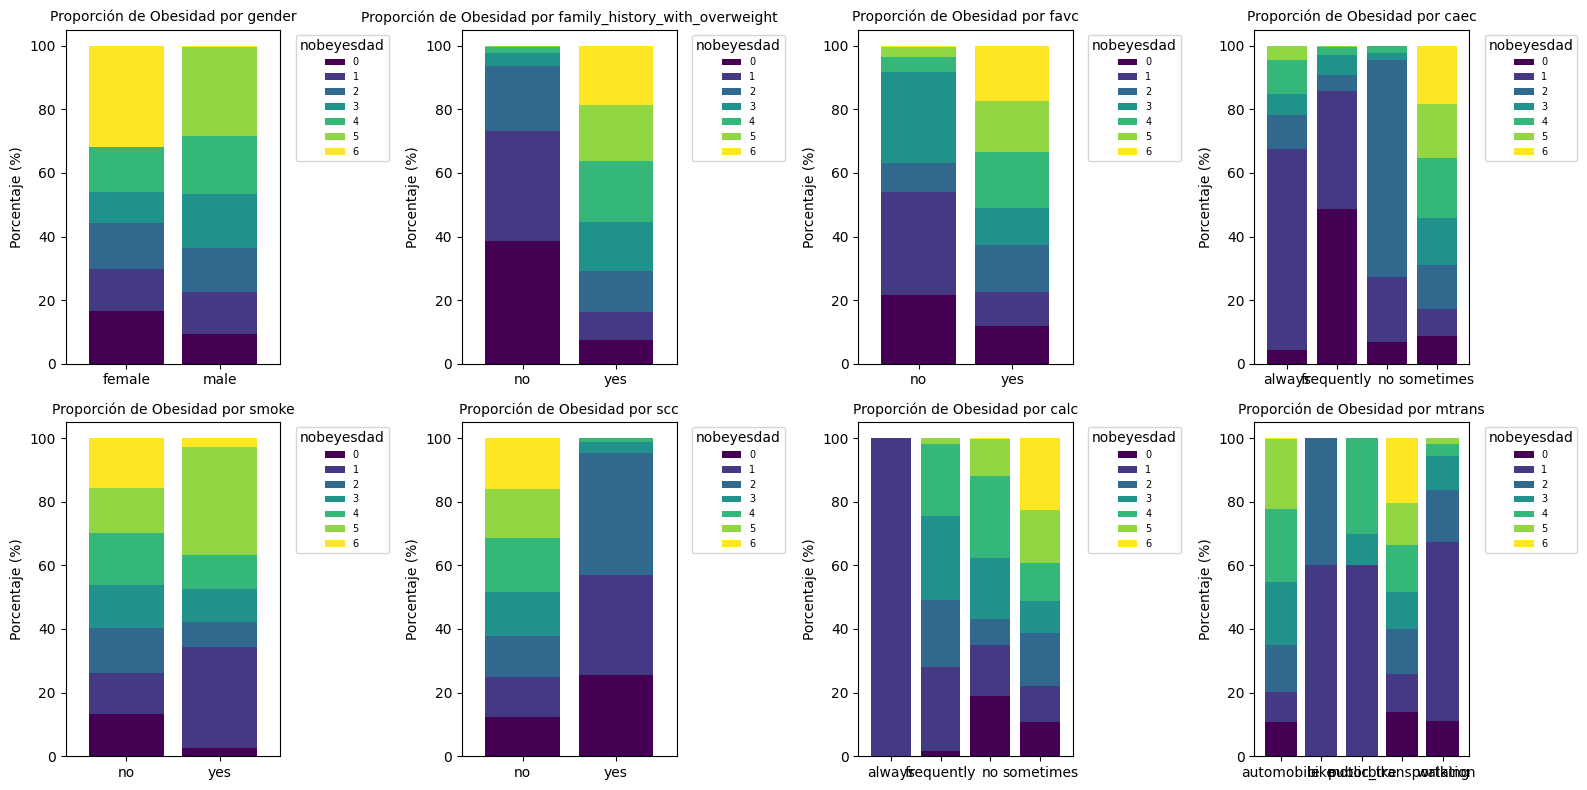


### 4. Prueba de Asociación Estadística (Chi-Cuadrado)

,Variable,Chi2 Statistic,P-Value,Asociación Significativa (p < 0.05)
3,caec,708.253770,1.005294e-138,True
0,gender,611.556131,7.497160e-129,True
1,family_history_with_overweight,556.735217,4.986678e-117,True
6,calc,301.554959,2.305965e-53,True
7,mtrans,275.956879,1.120167e-44,True
2,favc,208.721686,2.636509e-42,True
5,scc,117.208055,6.284021e-23,True
4,smoke,29.297034,5.344613e-05,True


In [17]:
analisis_exploratorio_categorico(df_final, variables_categoricas, variable_objetivo)

## 3.3.- Variable Objetivo

---

## **Análisis de la Variable Objetivo: 'nobeyesdad'**

---

### 1. Distribución de las Clases

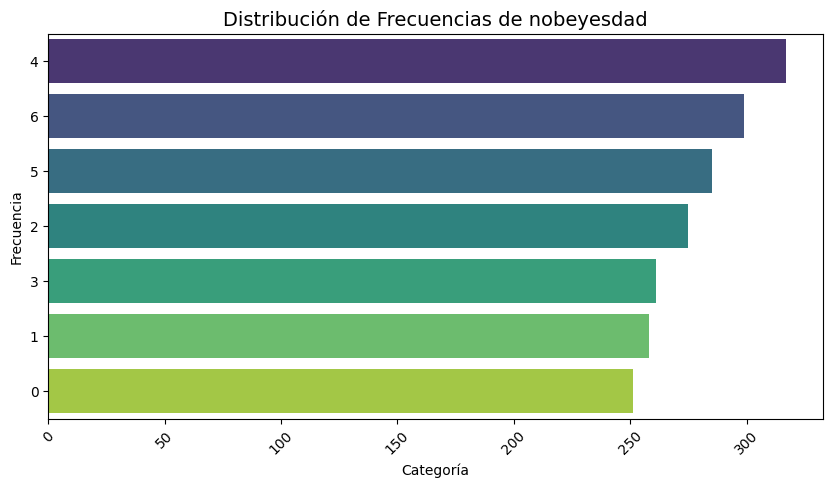


### 2. Perfil Categórico Más Común (Moda) por Categoría

Esta tabla muestra el hábito o característica más frecuente para cada nivel de obesidad.

,gender,family_history_with_overweight,favc,caec,smoke,scc,calc,mtrans
nobeyesdad,,,,,,,,
0,female,no,yes,sometimes,no,no,sometimes,public_transportation
1,male,yes,yes,sometimes,no,no,sometimes,public_transportation
2,male,yes,yes,sometimes,no,no,sometimes,public_transportation
3,male,yes,yes,sometimes,no,no,sometimes,public_transportation
4,male,yes,yes,sometimes,no,no,sometimes,public_transportation
5,male,yes,yes,sometimes,no,no,sometimes,public_transportation
6,female,yes,yes,sometimes,no,no,sometimes,public_transportation


In [18]:
analisis_variable_objetivo(df_final, variable_objetivo, variables_numericas, variables_categoricas)

# **4.- Guardar los Resultados**

In [ ]:
# Almacenar los resultados
guardar_dataframe_en_drive(df_final, 'df_fase1')

DataFrame guardado exitosamente en: /content/drive/MyDrive/Maestría MNA/Trimestre 4 Sep-Dic 25/Operaciones de aprendizaje automático/Edén/Proyecto/
